Install Dependencies

In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [ ]:
%pip install stable-baselines3[extra] protobuf==3.20.*

In [ ]:
%pip install mss pydirectinput pytesseract tesseract

In [ ]:
%pip install gymnasium

Import Dependencies

In [5]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import DQN


Constants

In [6]:
SPACE_ACTION = 'space'
DOWN_ACTION = 'down'
NO_OP_ACTION = 'no_op'
GAME_OVER_POSSIBLE_STRING_DETECTIONS = ['GAME', 'GAHE']

CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'
CALLBACK_CHECK_FREQ = 10000
VERBOSE = 1

DQN_POLICY = 'CnnPolicy'
DQN_BUFFER_SIZE = 20000
DQN_LEARNING_STARTS = 1000
DQN_TOTAL_TIMESTEPS = 200000
DQN_BEST_MODEL_PATH = 'best_model.zip'
DQN_LOAD_MODEL = True

Creating the Env

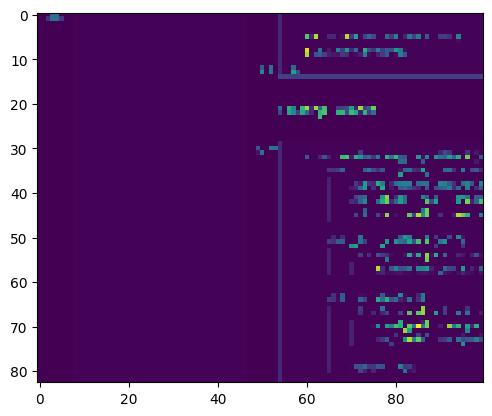

In [7]:
class DinoGame(Env):
    def __init__(self):
        super().__init__()

        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)

        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.game_over_location = {'top': 405, 'left': 630, 'width': 660, 'height': 70}

    def step(self, action):
        action_map = {
            0: SPACE_ACTION,
            1: DOWN_ACTION,
            2: GAME_OVER_POSSIBLE_STRING_DETECTIONS
        }

        if action != 2:
            pydirectinput.press(action_map[action])
        
        game_over = self.get_game_over()
        new_observation = self.get_observation()

        reward = 1
        truncated = None
        info = {}

        return new_observation, reward, game_over, truncated, info

    def render(self):
        cv2.imshow("", np.array(self.cap.grab(self.game_location)))[:,:,:3]
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close_observation

    def close_observation(self):
        cv2.destroyAllWindows()
  
    def reset(self, seed=None):
        time.sleep(2)
        pydirectinput.press(SPACE_ACTION)
        return self.get_observation(), seed

    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        
        return channel
        
    def get_game_over(self):
        game_over_cap = np.array(self.cap.grab(self.game_over_location))[:,:,:3]
        
        game_over = False

        string_detection = pytesseract.image_to_string(game_over_cap)[:4]
        if string_detection in GAME_OVER_POSSIBLE_STRING_DETECTIONS:
            game_over = True

        return game_over

env = DinoGame()

obs = env.get_observation()
plt.imshow(obs[0])

Creating Callback

In [8]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=VERBOSE):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
    
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, '{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

callback = TrainAndLoggingCallback(check_freq=CALLBACK_CHECK_FREQ, save_path=CHECKPOINT_DIR)

Building DQN and Train

In [9]:
model = None

if DQN_LOAD_MODEL is True:
    model = DQN.load(DQN_BEST_MODEL_PATH, env=env)
     
else:
    model = DQN(DQN_POLICY, env, tensorboard_log = LOG_DIR, verbose=VERBOSE, buffer_size=DQN_BUFFER_SIZE, learning_starts=DQN_LEARNING_STARTS)

model.learn(total_timesteps=DQN_TOTAL_TIMESTEPS, callback=callback) 
  

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/DQN_20


KeyboardInterrupt: 